# News Vendor Test

In [1]:
import scipy as sc
from sklearn import datasets
from matplotlib.style import available
from sklearn.cluster import KMeans
import numpy as np
import cvxpy as cp
import torch
import time
from cvxpylayers.torch import CvxpyLayer
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import pandas as pd
import warnings
# import mosek
warnings.filterwarnings('ignore')
plt.rcParams.update({
    "text.usetex":True,
    "font.size":18,
    "font.family": "serif"
})
colors = ["tab:blue", "tab:green", "tab:orange", 
          "tab:red", "tab:purple", "tab:brown", "tab:pink", "tab:grey", "tab:olive","tab:blue", "tab:orange", "tab:green",
          "tab:red", "tab:purple", "tab:brown", "tab:pink", "tab:grey", "tab:olive"]

ModuleNotFoundError: No module named 'mosek'

In [349]:
def createproblem_news(n):
    # PARAMETERS #
    A = cp.Parameter((n,n))
    b = cp.Parameter(n)
    # VARIABLES #
    # weights, s_i, lambda, tau
    x = cp.Variable(n)
    t = cp.Variable()
    gam = cp.Variable(n)
    # OBJECTIVE #
    objective = t
    k = np.array([2,3])
    p = np.array([3,4])

    # CONSTRAINTS #
    constraints = [ k@x -p@x + cp.norm(gam,2) <= t]
    constraints += [A.T@gam == p]
    constraints += [k@x + p@b + cp.norm(gam,2) <= t]
    constraints += [x >= 0]
    # PROBLEM #
    problem = cp.Problem(cp.Minimize(objective), constraints)
    return problem, x, t, A, b

def gen_demand(n, N):
    F = np.random.normal(size = (n,2))
    sig = 0.1*F@(F.T)
    mu = np.random.uniform(-0.2,3,n)
    norms = np.random.multivariate_normal(mu,sig, N)
    d_train = np.exp(norms)
    return d_train

def loss(x,t, data,l = 1): 
    return t + l*torch.mean(torch.maximum(
        torch.maximum(k@x -data@p, k@x - p@x) - t, 
        torch.tensor(0.,requires_grad = True))), t, torch.mean(torch.maximum(
        torch.maximum(k@x -data@p, k@x - p@x) - t, 
        torch.tensor(0.,requires_grad = True)))
                                                                                                                                                                                                                                                                                                 

In [76]:
loss(torch.tensor(5*np.ones(n)),torch.tensor(1),val_dset)

(tensor(2.3249, dtype=torch.float64, grad_fn=<AddBackward0>),
 tensor(1),
 tensor(1.3249, dtype=torch.float64, grad_fn=<MeanBackward0>))

In [382]:
n = 2
N = 15
k = torch.tensor(np.array([2.,3.]),requires_grad = True)
p = torch.tensor(np.array([3.,4.]), requires_grad = True)
data = gen_demand(n,N)
# data = np.concatenate((d1,d2))

In [383]:
w = 2
problem, x, t, A, b = createproblem_news(n)
cvxpylayer = CvxpyLayer(problem, parameters=[A, b], variables= [x,t])       
df2 = pd.DataFrame(columns=["step", "Opt_val", "Violations1", "Violations2","Eval_val", "Loss_val", "A_norm"])
init = np.eye(n)
paramb_tch = torch.tensor(-init@np.mean(train, axis=0), requires_grad=True)
paramT_tch = torch.tensor(init, requires_grad=True)
variables = [paramT_tch, paramb_tch]
opt = torch.optim.SGD(variables, lr=0.1, momentum=0.8)
for steps in range(step):
    var_values = cvxpylayer(paramT_tch, paramb_tch, solver_args={'solve_method': 'ECOS'})
    totloss, obj, v1 = loss(*var_values, val_dset, l=w)
    evalloss, _, v2 = loss(*var_values, eval_set, l=w)
    totloss.backward()
    newrow = pd.Series(
        {"step": steps,
         "Loss_val": totloss.item(),
         "Eval_val": evalloss.item(),
         "Opt_val": obj.item(),
         "Violations1": v1.item(),
         "Violations2": v2.item(),
         "A_norm": np.linalg.norm(paramT_tch.detach().numpy().copy())
         })
    df2 = pd.concat([df2, newrow.to_frame().T], ignore_index=True)
    if steps < step - 1:
        opt.step()
        opt.zero_grad()
A_fin = paramT_tch.detach().numpy().copy()
b_fin = paramb_tch.detach().numpy().copy()

problem, x, t, A, b = createproblem_news(n)
cvxpylayer = CvxpyLayer(problem, parameters=[A, b], variables= [x,t])  
df_eps = pd.DataFrame(columns=["step", "Opt_val", "Violations1", "Violations2","Eval_val", "Loss_val", "A_norm"])
eps_tch = torch.tensor(2.0, requires_grad=True)
paramb_tch = eps_tch*torch.tensor(-np.mean(train, axis=0), requires_grad=True)
paramT_tch = eps_tch*torch.tensor(np.eye(train.shape[1]), requires_grad=True)
variables = [eps_tch]
opt = torch.optim.SGD(variables, lr=0.001, momentum=0.8)
for steps in range(step):
    paramb_tch = eps_tch*torch.tensor(-np.mean(train, axis=0), requires_grad=True)
    paramT_tch = eps_tch*torch.tensor(np.eye(train.shape[1]), requires_grad=True)
    var_values = cvxpylayer(paramT_tch, paramb_tch, solver_args={'solve_method': 'ECOS'})
    totloss, obj, v1 = loss(*var_values, val_dset, l=w)
    evalloss, _, v2 = loss(*var_values, eval_set, l=w)
    totloss.backward()
    newrow = pd.Series(
        {"step": steps,
         "Loss_val": totloss.item(),
         "Eval_val": evalloss.item(),
         "Opt_val": obj.item(),
         "Violations1": v1.item(),
         "Violations2": v2.item(),
         "A_norm": eps_tch.detach().numpy().copy()
        })
    df_eps = pd.concat([df_eps, newrow.to_frame().T], ignore_index=True)
    if steps < step - 1:
        opt.step()
        opt.zero_grad()
        
problem, x, t, A, b = createproblem_news(n)
cvxpylayer = CvxpyLayer(problem, parameters=[A, b], variables= [x,t])  
df_grid = pd.DataFrame(columns=["step", "Opt_val", "Violations1", "Violations2","Eval_val", "Loss_val", "A_norm"])
paramb_tch = eps_tch*torch.tensor(-np.mean(train, axis=0), requires_grad=True)
paramT_tch = eps_tch*torch.tensor(np.eye(train.shape[1]), requires_grad=True)
epslist = np.logspace(-0.5,0.5,15)
for eps in epslist:
    eps_tch = torch.tensor(eps, requires_grad=True)
    paramb_tch = eps_tch*torch.tensor(-np.mean(train, axis=0), requires_grad=True)
    paramT_tch = eps_tch*torch.tensor(np.eye(train.shape[1]), requires_grad=True)
    var_values = cvxpylayer(paramT_tch, paramb_tch, solver_args={'solve_method': 'ECOS'})
    totloss, obj, v1 = loss(*var_values, val_dset, l=w)
    evalloss, _, v2 = loss(*var_values, eval_set, l=w)
    newrow = pd.Series(
        {"Loss_val": totloss.item(),
         "Eval_val": evalloss.item(),
         "Opt_val": obj.item(),
         "Violations1": v1.item(),
         "Violations2": v2.item(),
         "A_norm": eps_tch.detach().numpy().copy()
        })
    df_grid = pd.concat([df_grid, newrow.to_frame().T], ignore_index=True)
    
problem, x, t, A, b = createproblem_news(n)
cvxpylayer = CvxpyLayer(problem, parameters=[A, b], variables= [x,t])  
df_r1 = pd.DataFrame(columns=["step", "Opt_val", "Violations1", "Violations2","Eval_val", "Loss_val", "A_norm"])
paramb_tch = eps_tch*torch.tensor(b_fin)
paramT_tch = eps_tch*torch.tensor(A_fin)
epslist = np.logspace(-0.5,0.5,15)
for eps in epslist:
    eps_tch = torch.tensor(eps, requires_grad=True)
    paramb_tch = eps_tch*torch.tensor(b_fin)
    paramT_tch = eps_tch*torch.tensor(A_fin)
    var_values = cvxpylayer(paramT_tch, paramb_tch, solver_args={'solve_method': 'ECOS'})
    totloss, obj, v1 = loss(*var_values, val_dset, l=w)
    evalloss, _, v2 = loss(*var_values, eval_set, l=w)
    newrow = pd.Series(
        {"Loss_val": totloss.item(),
         "Eval_val": evalloss.item(),
         "Opt_val": obj.item(),
         "Violations1": v1.item(),
         "Violations2": v2.item(),
         "A_norm": eps_tch.detach().numpy().copy()
        })
    df_r1 = pd.concat([df_r1, newrow.to_frame().T], ignore_index=True)

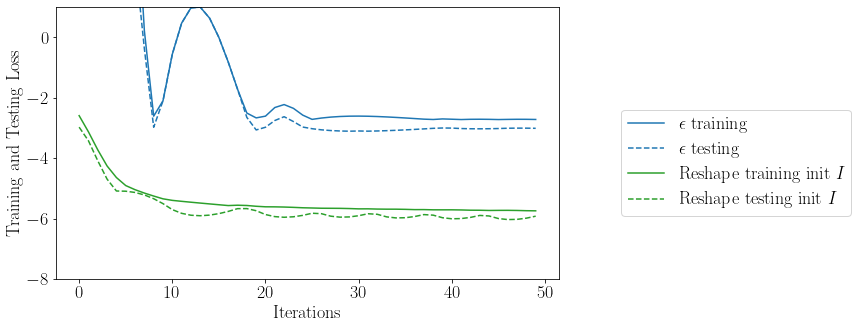

In [384]:
plt.figure(figsize=(9, 5))
plt.plot(df_eps['step'], df_eps['Loss_val'], color="tab:blue", label=r"$\epsilon$ training")
plt.plot(df_eps['step'], df_eps['Eval_val'], linestyle='--', color="tab:blue", label=r"$\epsilon$ testing")
# plt.plot(df1['step'], df1['Loss_val'], color="tab:orange", label="Reshape training init $\Sigma^{-1/2}$")
# plt.plot(df1['step'], df1['Eval_val'], linestyle='--', color="tab:orange", label="Reshape testing init $\Sigma^{-1/2}$")
plt.plot(df2['step'], df2['Loss_val'], color="tab:green", label="Reshape training init $I$")
plt.plot(df2['step'], df2['Eval_val'], linestyle='--', color="tab:green", label="Reshape testing init $I$")
plt.legend(loc="lower right", bbox_to_anchor=(1.6, 0.2))
plt.xlabel("Iterations")
plt.ylim([-8,1])
plt.ylabel("Training and Testing Loss")
plt.savefig("plot.pdf")


Text(0, 0.5, 'Testing Loss')

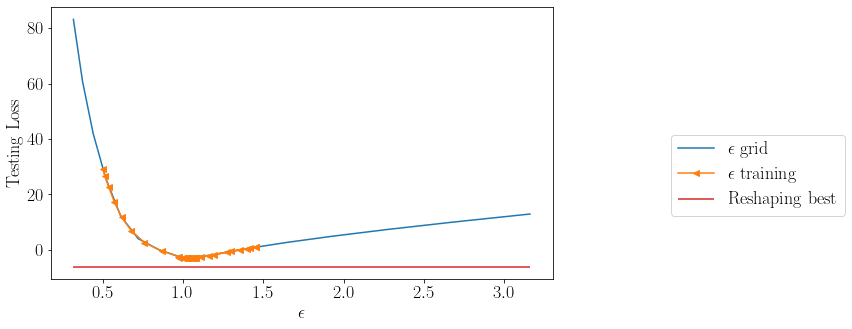

In [385]:
plt.figure(figsize=(9, 5))
plt.plot(1/epslist, df_grid['Eval_val'], color="tab:blue", label=r"$\epsilon$ grid")
plt.plot(1/df_eps["A_norm"],df_eps["Eval_val"], color="tab:orange", marker = "<", label=r"$\epsilon$ training" )
plt.hlines( xmin = np.min(epslist), xmax = np.max(epslist), y = np.min(df2["Eval_val"]), label = "Reshaping best", color= "tab:red")
plt.legend(loc="lower right", bbox_to_anchor=(1.6, 0.2))
plt.xlabel(r"$\epsilon$")
plt.ylabel("Testing Loss")

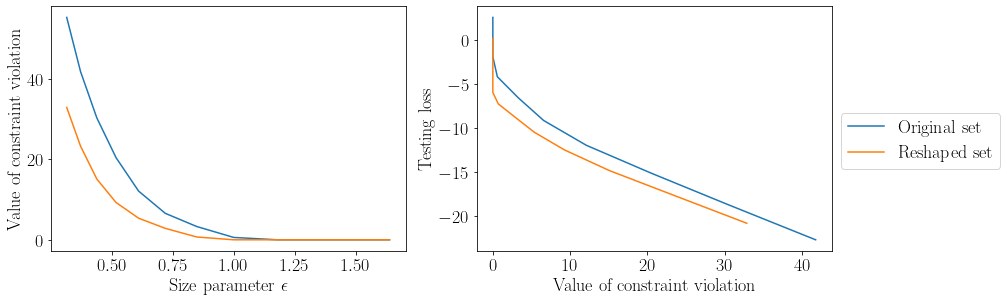

In [462]:

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4.5))
ax1.plot((1/df_grid['A_norm'])[4:], df_grid['Violations2'][4:], color="tab:blue", label=r"Original set")
ax1.plot((1/df_r1['A_norm'])[4:], df_r1['Violations2'][4:], color="tab:orange", label="Reshaped set")
ax1.set_xlabel("Size parameter $\epsilon$")
ax1.set_ylabel("Value of constraint violation")

ax2.plot(df_grid['Violations2'][4:14], df_grid['Opt_val'][4:14], color="tab:blue", label=r"Original set")
ax2.plot(df_r1['Violations2'],df_r1['Opt_val'], color="tab:orange", label="Reshaped set")
ax2.set_ylabel("Testing loss")
ax2.set_xlabel("Value of constraint violation")
lgd = ax2.legend(loc = "lower right", bbox_to_anchor=(1.5, 0.3))
plt.savefig("ex1_curves.pdf", bbox_extra_artists=(lgd,), bbox_inches='tight')


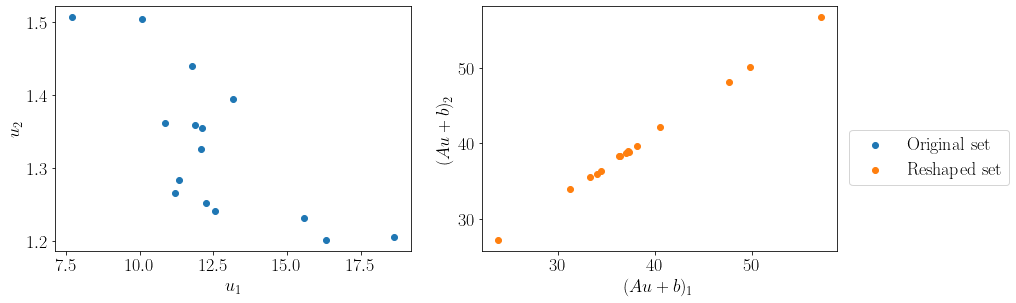

In [461]:
newdat = data@A_fin + b_fin
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4.5))
ax1.scatter(data[:,0],data[:,1],color="tab:blue", label=r"Original set")
ax1.set_ylabel("$u_2$")
ax1.set_xlabel("$u_1$")
ax2.scatter(newdat[:,0],newdat[:,1],color="tab:orange", label="Reshaped set")
ax2.set_ylabel("$(Au + b)_2$")
ax2.set_xlabel("$(Au + b)_1$")
lgd = fig.legend(loc = "lower right", bbox_to_anchor=(1.08, 0.3))
fig.savefig("ex1_graph.pdf", bbox_extra_artists=(lgd,), bbox_inches='tight')